# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [27]:
import pandas as pd
import numpy as np
import os
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Reshape
from tensorflow.keras.backend import epsilon
directory='images/'

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

### Change directory

In [3]:
os.listdir()

['.ipynb_checkpoints',
 'files.zip',
 'Images',
 'images',
 'images_racoon.rar',
 'R9 - ACV - Internal_Lab_Questions.ipynb',
 'train_labels.csv',
 'Untitled.ipynb']

In [4]:
def load_data(filename):
    file=open(filename, 'r')
    data=file.read()
    file.close()
    return data

### Load the training data from train.csv file

In [5]:
filename='train_labels.csv'
train_label_data=pd.read_csv(filename)
train_label_data.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127
5,raccoon-69.jpg,205,246,raccoon,12,11,188,240
6,raccoon-180.jpg,600,400,raccoon,119,21,368,399
7,raccoon-200.jpg,261,193,raccoon,107,10,249,166
8,raccoon-141.jpg,249,202,raccoon,1,1,154,176
9,raccoon-19.jpg,259,194,raccoon,87,8,182,89


### Print the shape of the train dataset

In [6]:
train_label_data.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [7]:
IMAGE_SIZE = 128 

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [8]:
import csv
with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height

In [32]:
paths

['raccoon-17.jpg',
 'raccoon-11.jpg',
 'raccoon-63.jpg',
 'raccoon-63.jpg',
 'raccoon-60.jpg',
 'raccoon-69.jpg',
 'raccoon-180.jpg',
 'raccoon-200.jpg',
 'raccoon-141.jpg',
 'raccoon-19.jpg',
 'raccoon-84.jpg',
 'raccoon-124.jpg',
 'raccoon-182.jpg',
 'raccoon-111.jpg',
 'raccoon-91.jpg',
 'raccoon-79.jpg',
 'raccoon-93.jpg',
 'raccoon-20.jpg',
 'raccoon-42.jpg',
 'raccoon-139.jpg',
 'raccoon-58.jpg',
 'raccoon-71.jpg',
 'raccoon-183.jpg',
 'raccoon-1.jpg',
 'raccoon-169.jpg',
 'raccoon-82.jpg',
 'raccoon-4.jpg',
 'raccoon-101.jpg',
 'raccoon-10.jpg',
 'raccoon-166.jpg',
 'raccoon-184.jpg',
 'raccoon-38.jpg',
 'raccoon-120.jpg',
 'raccoon-142.jpg',
 'raccoon-149.jpg',
 'raccoon-51.jpg',
 'raccoon-43.jpg',
 'raccoon-123.jpg',
 'raccoon-66.jpg',
 'raccoon-9.jpg',
 'raccoon-178.jpg',
 'raccoon-47.jpg',
 'raccoon-167.jpg',
 'raccoon-54.jpg',
 'raccoon-77.jpg',
 'raccoon-155.jpg',
 'raccoon-89.jpg',
 'raccoon-153.jpg',
 'raccoon-179.jpg',
 'raccoon-115.jpg',
 'raccoon-64.jpg',
 'raccoon-56

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [19]:
import cv2
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i,p in enumerate(paths):
    image = cv2.imread(directory+p,cv2.IMREAD_COLOR)
    if image is None: print(directory+p)
    if image is None: continue
    image = cv2.resize(image,(128,128))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    batch_images[i] = preprocess_input(np.array(image, dtype=np.float32))

In [20]:
batch_images[0].shape

(128, 128, 3)

In [21]:
len(paths)

173

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [22]:
model = MobileNet(input_shape=(128, 128, 3), include_top=False) 
for layer in model.layers:
    layer.trainable = False
model1 = model.layers[-1].output
model1 = Conv2D(4, kernel_size=4)(model1)
model1 = Reshape((4,))(model1)

myModel = Model(inputs=model.input,outputs = model1)

In [23]:
myModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Define a custom loss function IoU which calculates Intersection Over Union

In [24]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [25]:
myModel.compile(optimizer='Adam',loss='mse',metrics=[IoU])

In [28]:
myModel.fit(batch_images,coords,epochs=30,batch_size=32,verbose=1)

Train on 173 samples
Epoch 1/30
173/173 [==============================] - 0s 2ms/sample - loss: 3270.5531 - IoU: 0.1054
Epoch 2/30
173/173 [==============================] - 0s 571us/sample - loss: 606.3247 - IoU: 0.4595
Epoch 3/30
173/173 [==============================] - 0s 610us/sample - loss: 497.0581 - IoU: 0.5608
Epoch 4/30
173/173 [==============================] - 0s 589us/sample - loss: 598.0470 - IoU: 0.5416
Epoch 5/30
173/173 [==============================] - 0s 612us/sample - loss: 345.0605 - IoU: 0.6205
Epoch 6/30
173/173 [==============================] - 0s 593us/sample - loss: 207.4695 - IoU: 0.6504
Epoch 7/30
173/173 [==============================] - 0s 606us/sample - loss: 211.4520 - IoU: 0.6378
Epoch 8/30
173/173 [==============================] - 0s 591us/sample - loss: 186.1272 - IoU: 0.6773
Epoch 9/30
173/173 [==============================] - 0s 613us/sample - loss: 151.8829 - IoU: 0.7098
Epoch 10/30
173/173 [==============================] - 0s 588us/sample 

### Pick a test image from the given data

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [94]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def predict(path):
    
    test_batch_images = np.zeros((1, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
    image = cv2.imread(directory+path,cv2.IMREAD_COLOR)
    if image is None: print(directory+p)
    image = cv2.resize(image,(128,128))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    test_batch_images[0] = preprocess_input(np.array(image, dtype=np.float32))
    
    region=myModel.predict(test_batch_images)[0]
    
    region=np.array(region, dtype=np.float32)
    
    testImage=cv2.imread(directory+path)
    #testImage=cv2.resize(testImage,(128,128))
    
    image_height, image_width, channels = testImage.shape
    print(testImage.shape)
    x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
    y0 = int(region[1] * image_height / IMAGE_SIZE)

    x1 = int((region[2]) * image_width / IMAGE_SIZE)
    y1 = int((region[3]) * image_height / IMAGE_SIZE)


    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(testImage)

    # Create a Rectangle patch
    rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()
    

### Predict the coordinates of the bounding box for the given test image

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

(187, 270, 3)


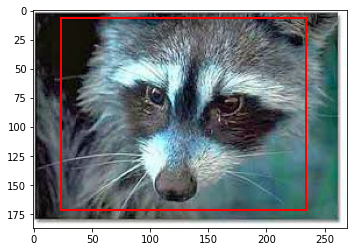

In [102]:
predict('raccoon-5.jpg')

(194, 259, 3)


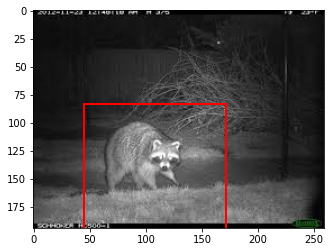

In [103]:

predict('raccoon-155.jpg')

(226, 223, 3)


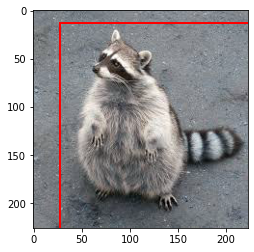

In [104]:
predict('raccoon-78.jpg')

(573, 800, 3)


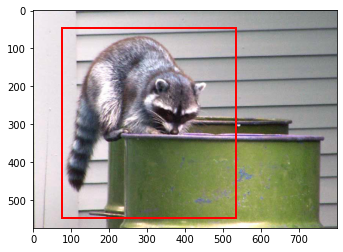

In [105]:
predict('raccoon-2.jpg')

(360, 480, 3)


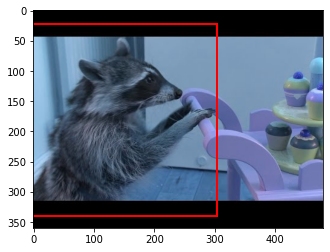

In [106]:
predict('raccoon-6.jpg')

(432, 660, 3)


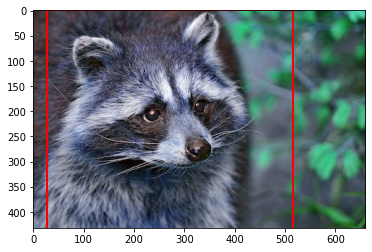

In [107]:
predict('raccoon-11.jpg')